In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from diffusers.utils import load_image

from pipeline_interpolated_sdxl_ip import InterpolationStableDiffusionXLPipeline
from prior import generate_beta_tensor
from utils import show_images_horizontally

xl_pipe = InterpolationStableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
)
xl_pipe.load_interpolated_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")
# xl_pipe.set_ip_adapter_scale(0.6)
generator = torch.cuda.manual_seed(1002)
dtype = torch.float16
xl_pipe.to("cuda", dtype=dtype)
size = xl_pipe.default_sample_size

Loading pipeline components...: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]
/home/qiyuan/.conda/envs/AID/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
latent_start = torch.randn((1, 4, size, size,), device="cuda", dtype=dtype, generator=generator)
# latent_end = torch.randn((1, 4, size, size,), device="cuda", dtype=dtype, generator=generator)

tensor([0.3264, 0.5000, 0.6738], device='cuda:0', dtype=torch.float16)


100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


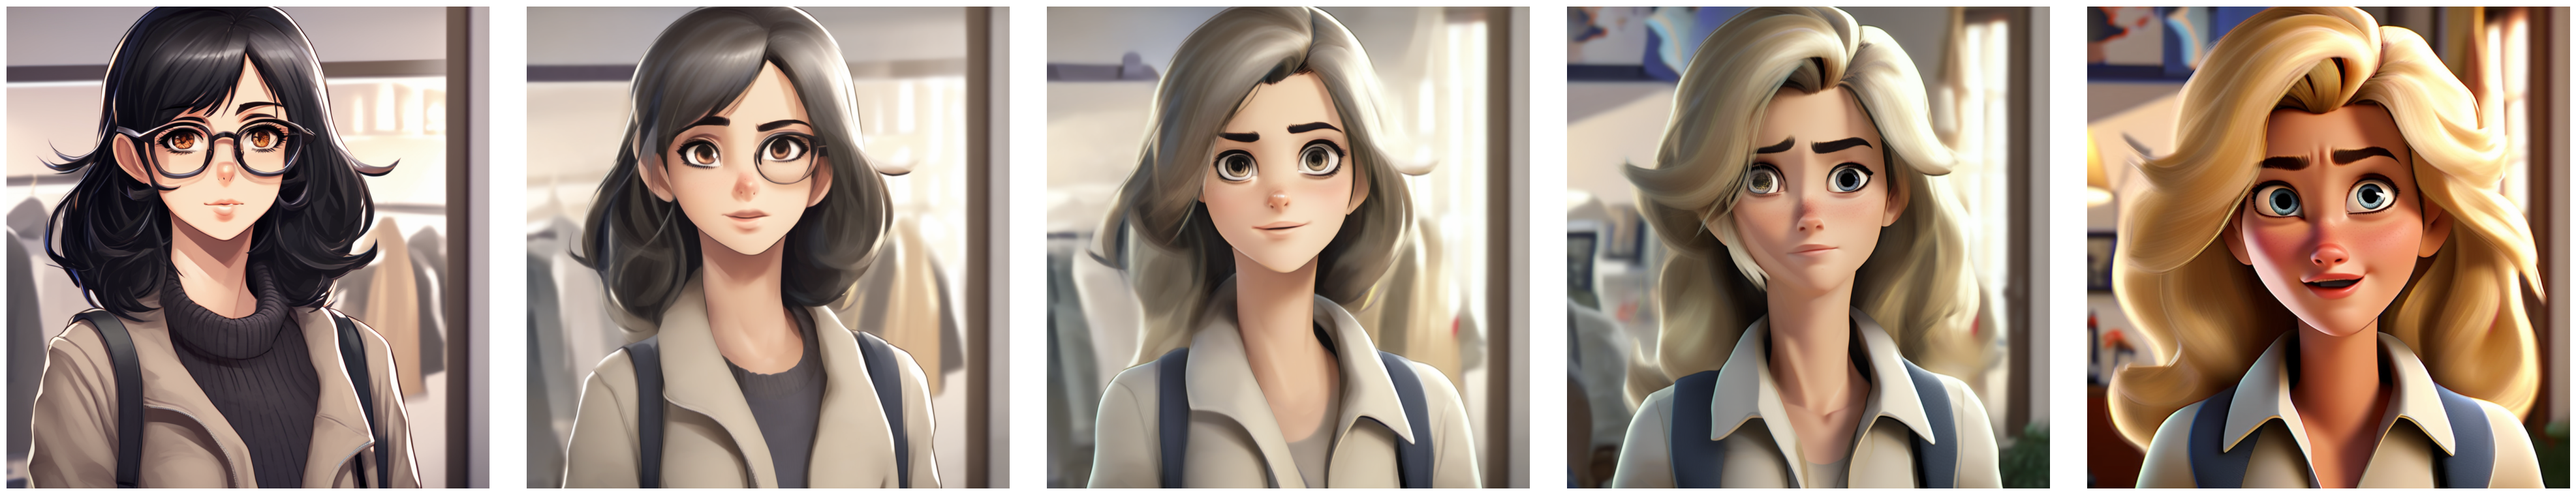

In [4]:
prompt_a = ""
prompt_b = ""
image_a = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_girl1.png")
image_b = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_mask_girl2.png")
negative_prompt = ""
interpolation_size = 5
num_inference_steps = 50
warmup_ratio = 0.5
sequence_coefficients = generate_beta_tensor(interpolation_size, alpha=2, beta=2).to(dtype=torch.float16, device="cuda")
sequence_coefficients = sequence_coefficients[1:-1]
print(sequence_coefficients)
results = []
for i in range(interpolation_size - 2):
    images = xl_pipe.interpolate_single(sequence_coefficients[i], prompt_start=prompt_a, prompt_end=prompt_b, image_start=image_a, image_end=image_b, negative_prompt=negative_prompt, latent_start=latent_start, latent_end=latent_start, early='fused_outer', num_inference_steps=num_inference_steps, output_type="np")
    if i == 0:
        results.append(images.images[0])
    results.append(images.images[1])
results.append(images.images[2])
show_images_horizontally(results, interact=True)